# Sentiment Analysis Pipeline
Notebook này thực hiện toàn bộ quy trình từ xử lý dữ liệu thô đến training và đánh giá model

In [1]:
import sys
import os

# Add project root to path
project_root = os.path.dirname(os.getcwd())
sys.path.append(project_root)

# Import các module cần thiết
from src.config import Config
from src.data.data_loader import DataLoader
from src.data.preprocessor import DataPreprocessor 
from src.features.feature_engineering import FeatureExtractor
from src.models.model_trainer import EnhancedModelTrainer
from src.models.model_predictor import SentimentPredictor
from src.utils.evaluation import ModelEvaluator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

## 1. Cấu hình và Khởi tạo

In [2]:
# Khởi tạo config
config = Config()

# Chọn ngôn ngữ
language = 'vi'  # hoặc 'en'

# Khởi tạo các component
data_loader = DataLoader(config)
preprocessor = DataPreprocessor(language, config)
feature_extractor = FeatureExtractor(language, config)
model_trainer = EnhancedModelTrainer(language, config)
evaluator = ModelEvaluator(language)

Loaded feature extractor with None dimensions


## 2. Load và Xử lý Dữ liệu

In [3]:
# Load raw data
file_path = os.path.join(config.DATA_DIR, 'raw', f'{language}_social_media.csv')
df = data_loader.load_data(file_path)

# Hiển thị thông tin cơ bản
print("Dataset Info:")
print(f"Total samples: {len(df)}")
print("\nClass distribution:")

# checking if labels is exists in the dataset
if 'label' in df.columns:
    print(df['label'].value_counts())
else:
    print("No label column found in the dataset")

# Preprocess data
processed_df = preprocessor.preprocess(df)

# Save processed data to file
processed_data_path = os.path.join(config.DATA_DIR, 'processed', f'{language}_processed.csv')
preprocessor.save_processed_data(processed_df, processed_data_path)

# Split data
train_df, test_df = data_loader.split_data(processed_df)

# Get features and labels
X_train, y_train = data_loader.get_features_and_labels(train_df)
X_test, y_test = data_loader.get_features_and_labels(test_df)

Dataset Info:
Total samples: 10000

Class distribution:
No label column found in the dataset
2024-11-29 18:34:04,264 - src.data.preprocessor - INFO - Preprocessing vi data...
2024-11-29 18:34:10,074 - src.data.preprocessor - INFO - Preprocessed 7700 valid samples
2024-11-29 18:34:10,097 - src.data.preprocessor - INFO - Saved processed data to c:\users\tamaisme\desktop\projects\python\project\vietnamese-english-sentiment-analysis-system\data\processed\vi_processed.csv
2024-11-29 18:34:10,099 - src.data.data_loader - INFO - Class distribution before split: {0: 0.4944155844155844, 2: 0.39025974025974025, 1: 0.11532467532467533}
2024-11-29 18:34:10,104 - src.data.data_loader - INFO - Training set size: 5390 samples
2024-11-29 18:34:10,105 - src.data.data_loader - INFO - Test set size: 2310 samples
2024-11-29 18:34:10,106 - src.data.data_loader - INFO - Training distribution: {0: 0.49443413729128016, 2: 0.3901669758812616, 1: 0.11539888682745826}
2024-11-29 18:34:10,106 - src.data.data_load

## 3. Phân tích Dữ liệu

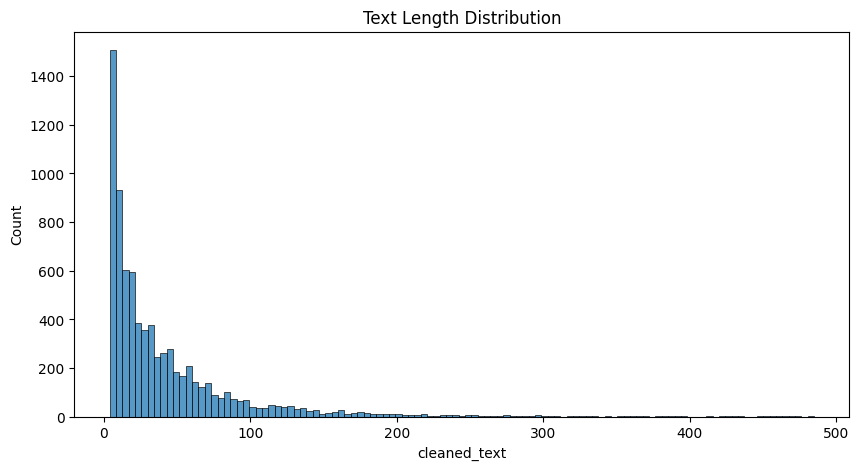

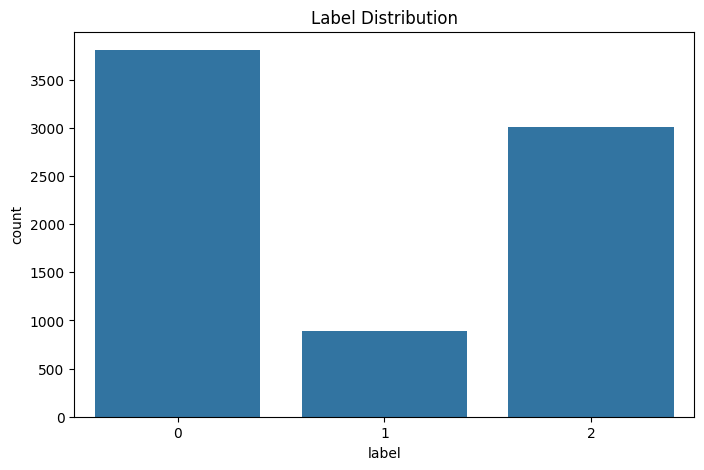

In [4]:
# Phân tích độ dài văn bản
plt.figure(figsize=(10, 5))
text_lengths = processed_df['cleaned_text'].str.len()
sns.histplot(text_lengths)
plt.title('Text Length Distribution')
plt.show()

# Phân tích phân phối nhãn
plt.figure(figsize=(8, 5))
sns.countplot(data=processed_df, x='label')
plt.title('Label Distribution')
plt.show()

## 4. Feature Engineering

In [5]:
# Extract features
X_train_features = feature_extractor.extract_features(X_train)
X_test_features = feature_extractor.extract_features(X_test)

print("Feature shapes:")
print(f"Training features: {X_train_features.shape}")
print(f"Testing features: {X_test_features.shape}")

Word features shape: (5390, 2000)
Char features shape: (5390, 500)
Tfidf features shape: (5390, 2000)
Linguistic features shape: (5390, 6)
Emotion features shape: (5390, 15)
All features shape after hstack: (5390, 4521)
Word features shape: (2310, 2000)
Char features shape: (2310, 500)
Tfidf features shape: (2310, 2000)
Linguistic features shape: (2310, 6)
Emotion features shape: (2310, 15)
All features shape after hstack: (2310, 4521)
Feature shapes:
Training features: (5390, 4521)
Testing features: (2310, 4521)


## 5. Training Model

In [6]:
import joblib

# Train models
models = model_trainer.train_with_grid_search(X_train, y_train)

# Check if models is not None
if models:
    # Save checkpoint
    checkpoint_path = os.path.join(config.DATA_DIR, 'checkpoints', f'{language}_checkpoint.pkl')
    joblib.dump(models, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")

    # Get best model performance
    best_model_name = max(models.items(), key=lambda x: getattr(x[1], 'best_score_', 0))[0]
    best_model = models[best_model_name]

    print(f"Best model: {best_model_name}")
    print(f"Best score: {getattr(best_model, 'best_score_', 0):.4f}")
else:
    print("No models were trained.")

2024-11-29 18:34:12,191 - src.models.model_trainer - INFO - Starting model training...
Loaded feature extractor with None dimensions
Word features shape: (5390, 2000)
Char features shape: (5390, 500)
Tfidf features shape: (5390, 2000)
Linguistic features shape: (5390, 6)
Emotion features shape: (5390, 15)
All features shape after hstack: (5390, 4521)
Word features shape: (5390, 2000)
Char features shape: (5390, 500)
Tfidf features shape: (5390, 2000)
Linguistic features shape: (5390, 6)
Emotion features shape: (5390, 15)
All features shape after hstack: (5390, 4521)
2024-11-29 18:34:14,721 - src.models.model_trainer - INFO - 
Training rf model...
2024-11-29 18:34:44,264 - src.models.model_trainer - INFO - Fold 1/10 - Train: 0.7658, Val: 0.7407
2024-11-29 18:35:09,427 - src.models.model_trainer - INFO - Fold 2/10 - Train: 0.7712, Val: 0.6910
2024-11-29 18:35:37,849 - src.models.model_trainer - INFO - Fold 3/10 - Train: 0.7663, Val: 0.7176
2024-11-29 18:36:05,949 - src.models.model_train

## 6. Đánh giá Model

Loaded feature extractor with None dimensions
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78      1142
           1       0.25      0.23      0.24       266
           2       0.80      0.73      0.76       902

    accuracy                           0.71      2310
   macro avg       0.60      0.59      0.60      2310
weighted avg       0.71      0.71      0.71      2310



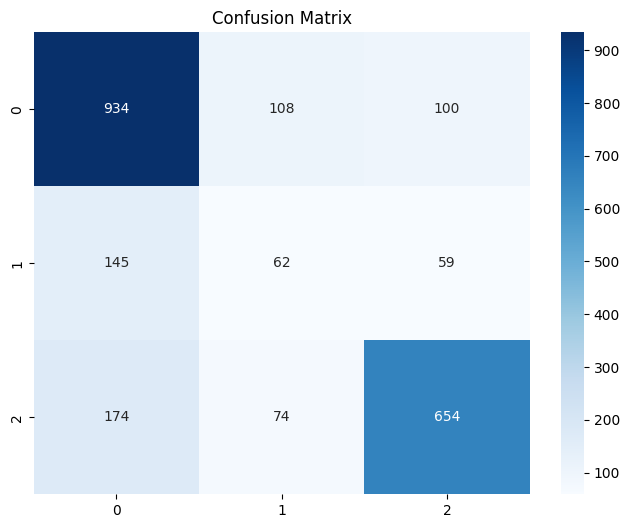

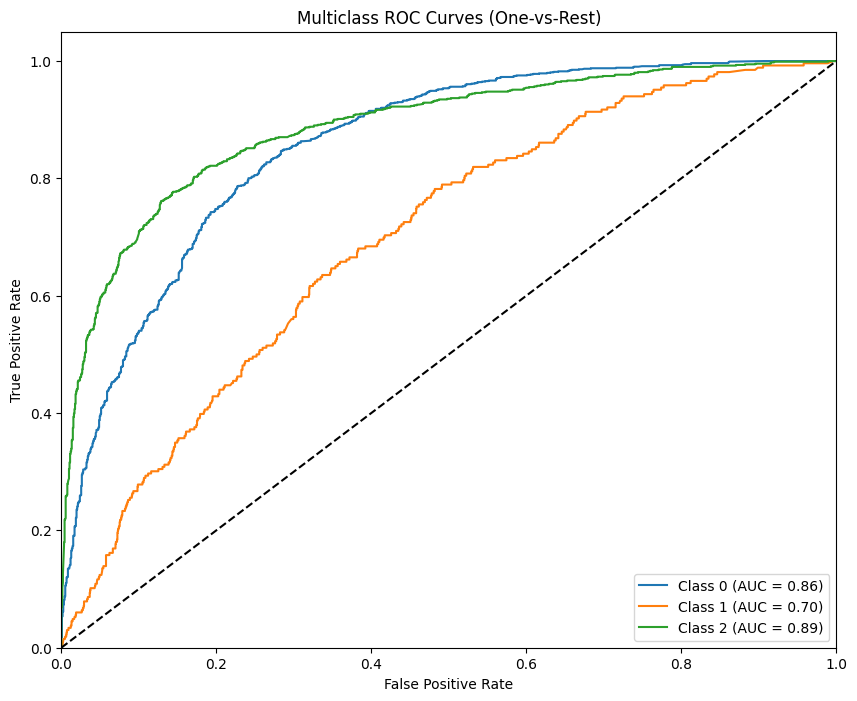

In [7]:
# Initialize predictor
predictor = SentimentPredictor(language, config)

# Make predictions
predictions = predictor.predict(X_test_features)
probabilities = predictor.predict_proba(X_test_features)

# Modified evaluation code to handle multiclass
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np

# Basic metrics
results = {
    'classification_report': classification_report(y_test, predictions),
    'confusion_matrix': confusion_matrix(y_test, predictions)
}

# Display results
print("Classification Report:")
print(results['classification_report'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC curves for each class
n_classes = probabilities.shape[1]
plt.figure(figsize=(10, 8))

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    # Convert to one-vs-rest binary format
    y_test_binary = (y_test == i).astype(int)
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test_binary, probabilities[:, i])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves (One-vs-Rest)')
plt.legend(loc="lower right")
plt.show()

## 7. Thử nghiệm Model

In [8]:
# Test with sample texts
test_texts = [
    "Sản phẩm rất tốt, tôi rất thích",
    "Chất lượng kém, không đáng tiền",
    "Tạm được, không tốt không xấu"
]

# Process and predict
for text in test_texts:
    # Preprocess
    df = pd.DataFrame({'text': [text]})
    processed = preprocessor.preprocess(df)
    
    # Extract features
    features = feature_extractor.extract_features(processed['cleaned_text'])
    
    # Get prediction with emotion
    result = predictor.predict_emotion(features, text)
    
    # Display results
    print(f"\nText: {text}")
    print(f"Sentiment: {result['sentiment']}")
    print(f"Confidence: {result['sentiment_confidence']:.4f}")
    print(f"Emotion: {result['emotion']} ({result['emotion_vi']}) {result['emotion_emoji']}")

2024-11-29 18:37:48,317 - src.data.preprocessor - INFO - Preprocessing vi data...
2024-11-29 18:37:48,321 - src.data.preprocessor - INFO - Preprocessed 1 valid samples
Word features shape: (1, 2000)
Char features shape: (1, 500)
Tfidf features shape: (1, 2000)
Linguistic features shape: (1, 6)
Emotion features shape: (1, 15)
All features shape after hstack: (1, 4521)

Text: Sản phẩm rất tốt, tôi rất thích
Sentiment: 2
Confidence: 0.8136
Emotion: happy (vui vẻ) 😊
2024-11-29 18:37:48,512 - src.data.preprocessor - INFO - Preprocessing vi data...
2024-11-29 18:37:48,515 - src.data.preprocessor - INFO - Preprocessed 1 valid samples
Word features shape: (1, 2000)
Char features shape: (1, 500)
Tfidf features shape: (1, 2000)
Linguistic features shape: (1, 6)
Emotion features shape: (1, 15)
All features shape after hstack: (1, 4521)

Text: Chất lượng kém, không đáng tiền
Sentiment: 0
Confidence: 0.4666
Emotion: disappointed (thất vọng) 😞
2024-11-29 18:37:48,695 - src.data.preprocessor - INFO -

## 8. Phân tích Hiệu năng chi tiết

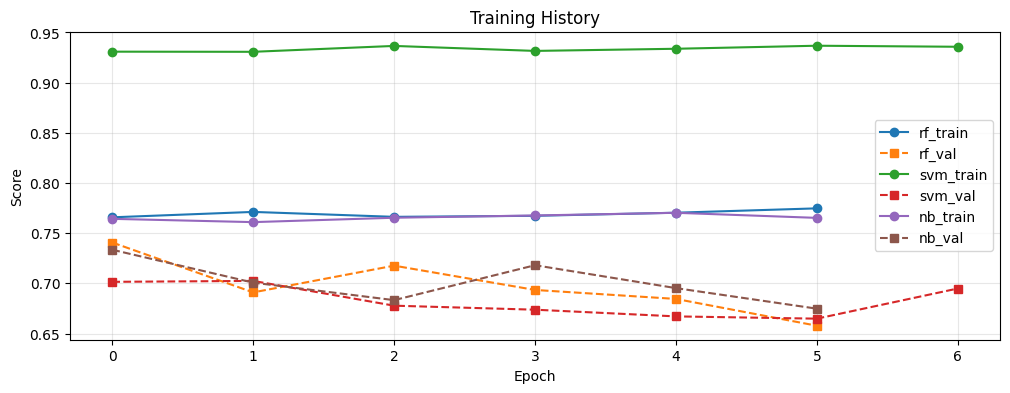

In [9]:
# Lấy metrics từ model_info
model_path = os.path.join(config.DATA_DIR, "models", f"{language}_sentiment_model.pkl")
model_info = joblib.load(model_path)
metrics = model_info['metrics']

# Hiển thị training history
if 'training_history' in metrics:
    plt.figure(figsize=(12, 4))
    for model_name, history in metrics['training_history'].items():
        plt.plot(history['train_scores'], 'o-', label=f'{model_name}_train')
        plt.plot(history['valid_scores'], 's--', label=f'{model_name}_val')
    
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Hiển thị feature importance nếu có
if models and 'rf' in models and hasattr(models['rf'], 'feature_importances_'):
    importances = models['rf'].feature_importances_
    plt.figure(figsize=(10, 4))
    plt.bar(range(len(importances)), importances)
    plt.title('Feature Importance')
    plt.show()